# HW 3 - Synonym Detection In Spark - Shishir Agarwal (Please note Q#6 takes about 40 minutes to complete on my cluster)
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the last homework assignment you performed Naive Bayes to classify documents as 'ham' or 'spam.' In doing so, we relied on the implicit assumption that the list of words in a document can tell us something about the nature of that document's content. We'll rely on a similar intuition this week: the idea that, if we analyze a large enough corpus of text, the list of words that appear in small window before or after a vocabulary term can tell us something about that term's meaning.

This will be your first assignment working in Spark. You'll perform Synonym Detection by repurposing an algorithm commonly used in Natural Language Processing to perform document similarity analysis. In doing so you'll also become familiar with important datatypes for efficiently processing sparse vectors and a number of set similarity metrics (e.g. Cosine, Jaccard, Dice). By the end of this homework you should be able to:  
* ... __define__ the terms `one-hot encoding`, `co-occurrance matrix`, `stripe`, `inverted index`, `postings`, and `basis vocabulary` in the context of both synonym detection and document similarity analysis.
* ... __explain__ the reasoning behind using a word stripe to compare word meanings.
* ... __identify__ what makes set-similarity calculations computationally challenging.
* ... __implement__ stateless algorithms in Spark to build stripes, inverted index and compute similarity metrics.
* ... __apply__ appropriate metrics to assess the performance of your synonym detection algorithm. 


__`NOTE`__: your reading assignment for weeks 5 and 6 were fairly heavy and you may have glossed over the papers on dimension independent similarity metrics by [Zadeh et al](http://stanford.edu/~rezab/papers/disco.pdf) and pairwise document similarity by [Elsayed et al](https://terpconnect.umd.edu/~oard/pdf/acl08elsayed2.pdf). If you haven't already, this would be a good time to review those readings -- they are directly relevant to this assignment.

__Please refer to the `README` for homework submission instructions and additional resources.__

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [0]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Run the next cell to create your directory in dbfs
You do not need to understand this scala snippet. It simply dynamically fetches your user directory name so that any files you write can be saved in your own directory.

In [0]:
# RUN THIS CELL AS IS
# This code snippet reads the user directory name, and stores is in a python variable.
# Next, it creates a folder inside your home folder, which you will use for files which you save inside this notebook.
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
hw3_path = userhome + "/hw3/" 
hw3_path_open = '/dbfs' + hw3_path.split(':')[-1] # for use with python open()
dbutils.fs.mkdirs(hw3_path)

dbfs:/user/shishir.agarwal@ischool.berkeley.edu
Out[20]: True

In [0]:
# RUN THIS CELL AS IS - A test to make sure your directory is working as expected.
# You should see a result like:
# dbfs:/user/youremail@ischool.berkeley.edu/hw3/sample_docs.txt
dbutils.fs.put(hw3_path+'test.txt',"hello world",True)
display(dbutils.fs.ls(hw3_path))

Wrote 11 bytes.

path,name,size
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/hw3/basis.txt,basis.txt,11948
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/hw3/sample_docs.txt,sample_docs.txt,144
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/hw3/stripes/,stripes/,0
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/hw3/systems_test.txt,systems_test.txt,493
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/hw3/test.txt,test.txt,11
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/hw3/vocabulary.txt,vocabulary.txt,113523


In [0]:
# RUN THIS CELL AS IS. You should see multiple google-eng-all-5gram-* files in the results. If you do not see these, please let an Instructor or TA know.
display(dbutils.fs.ls('/mnt/mids-w261/HW3/'))

path,name,size
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-0-filtered.txt,googlebooks-eng-all-5gram-20090715-0-filtered.txt,11444614
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-1-filtered.txt,googlebooks-eng-all-5gram-20090715-1-filtered.txt,0
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-10-filtered.txt,googlebooks-eng-all-5gram-20090715-10-filtered.txt,11447003
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-100-filtered.txt,googlebooks-eng-all-5gram-20090715-100-filtered.txt,11484723
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-101-filtered.txt,googlebooks-eng-all-5gram-20090715-101-filtered.txt,11473190
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-102-filtered.txt,googlebooks-eng-all-5gram-20090715-102-filtered.txt,11411047
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-103-filtered.txt,googlebooks-eng-all-5gram-20090715-103-filtered.txt,11479296
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-104-filtered.txt,googlebooks-eng-all-5gram-20090715-104-filtered.txt,11426686
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-105-filtered.txt,googlebooks-eng-all-5gram-20090715-105-filtered.txt,11482267
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-106-filtered.txt,googlebooks-eng-all-5gram-20090715-106-filtered.txt,11466886


In [0]:
# get Spark Session info (RUN THIS CELL AS IS)
spark

Out[23]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.0.1 
 Master 
 spark://10.99.251.185:7077 
 AppName 
 Databricks Shell

In [0]:
# start SparkContext (RUN THIS CELL AS IS)
sc = spark.sparkContext

In [0]:
# OPTIONAL
# Spark configuration Information (RUN THIS CELL AS IS)
# sc.getConf().getAll()

__`REMINDER:`__ If you are running this notebook in databricks, you can monitor the progress of your jobs using the Spark UI by clicking on "view" in the output cell below the cell you are running

# Question 1: Spark Basics.
In your readings and live session demos for weeks 4 and 5 you got a crash course in working with Spark. We also talked about how Spark RDDs fit into the broader picture of distributed algorithm design. The questions below cover key points from these discussions. Feel free to answer each one very briefly.

### Q1 Tasks:

* __a) short response:__ What is Spark? How  does it relate to Hadoop MapReduce?

* __b) short response:__ In what ways does Spark follow the principles of statelessness (a.k.a. functional programming)? List at least one way in which it allows the programmer to depart from this principle. 

* __c) short response:__ In the context of Spark what is a 'DAG' and how do they relate to the difference between an 'action' and a 'transformation'? Why is it useful to pay attention to the DAG that underlies your Spark implementation?

* __d) short response:__ Give a specific example of when we would want to `cache()` an RDD and explain why.

### Q1 Student Answers:
> __a)__ Apache Spark is an open source project that provides high-performance, general-purpose distributed computing. It enables us to process large quantities of data, beyond what can fit on a single machine, with a high-level easy-to-use API. It allows us to write the logic of data transformations in a way that can be executed across a cluser of compute nodes. MapReduce, similar to Spark, is used for high-performance, general-purpose distributed computing based on functional programming paradigm however its design principles are quite different which makes Spark 100x faster than MapReduce, allows Spark to be more interactive (REPL) than MapReduce and performs low latency SQL queries on streaming and batch data which is difficult for MapReduce to process. Spark is next generation technology to MapReduce allowing more batch, streaming, interactive analysis of large data sets.

> __b)__ Spark supports lots of design principles of functional programming however it does not support full functionality of functional programming. For example, functional programming paradigm supports higher order function which take functions as arguments. Spark has built-in map, filter, reduce functions that take other functions as arguments. Also, Spark does not modify input data (RDD) instead it generates a new data structure that represents an output of the transformation. Lastly, Spark follows lazy eveluation which is central to the functional programming paradigm. Typically functional programming does not allow for side effects which means the state of the program does not change with the input parameters. This design principle of functional programming is not preserved in Spark since Spark supports shared variables (Accumulators and Broadcast) that can hold state which departs from true functional programming paradigm.

> __c)__ Evaluation of RDDs in Spark is lazy. Spark does not begin computing the partitions until an action is called. An action like (reduce, count, save etc.) triggers evaluation of partitions, which in turn trigger the scheduler, which builds a directed acyclic graph (called the DAG), based on the dependencies between RDD transformations (map, filter etc.) In other words, Spark evaluates an action by working backward to define the series of steps it has to take to take to evaluate each partition. Then, using this series of steps, called the execution plan, the scheduler computes the missing partitions for each stage until it computes the final result. It is important to pay attention to DAG especially in debugging because if there is a bug during the transformation phase it will not get uncovered until one calls an action. Once the action is called then specific transformation gets executed and at that time if there is a bug it will surface itself.

> __d)__ Spark RDDs are lazily evaluated, and sometimes we may wish to use the same RDD multiple times. If we do this without caching, Spark will recompute the RDD and all of its dependencies each time we call an action on the RDD. This can be especially expensive for iterative algorithms. To avoid computing an RDD multiple times, we can ask Spark to cache the data which can be used multiple times without starting from scratch and recomputing the RDD.

# Question 2: Similarity Metrics
As mentioned in the introduction to this assignment, an intuitive way to compare the meaning of two documents is to compare the list of words they contain. Given a vocabulary $V$ (feature set) we would represent each document as a vector of `1`-s and `0`-s based on whether or not it contains each word in $V$. These "one-hot encoded" vector representations allow us to use math to identify similar documents. However like many NLP tasks the high-dimensionality of the feature space is a challenge... especially when we start to scale up the size and number of documents we want to compare.

In this question we'll look at a toy example of document similarity analysis. Consider these 3 'documents': 
```
docA	the flight of a bumblebee
docB	the length of a flight
docC	buzzing bumblebee flight
```
These documents have a total of __7__ unique words: 
>`a, bumblebee, buzzing, flight, length, of, the`.     

Given this vocabulary, the documents' vector representations are (note that one-hot encoded entries follow the order of the vocab list above):

```
docA	[1,1,0,1,0,1,1]
docB	[1,0,0,1,1,1,1]
docC	[0,1,1,1,0,0,0]
```  

### Q2 Tasks:

* __a) short response:__ The cosine similarity between two vectors is $$ \frac{A\cdot B}{\|A\|\|B\|} $$. Explain what the the numerator and denominator of this calculation would represent in terms of word counts in documents A and B. 

* __b) short response:__ Explain how the Jaccard, Overlap and Dice metrics are similar/different to the calculation for cosine similarity. When would these metrics lead to different similarity rankings for a set of documents?

* __c) short response:__ Calculate the cosine similarity for each pair of documents in our toy corpus. Please use markdown and $\LaTeX$ to show your calcuations.  

* __d) short response:__ According to your calculations in `part c` which pair of documents are most similar in meaning? Does this match your expecatation from reading the documents? If not, speculate about why we might have gotten this result.

* __e) short response:__ In NLP common words like '`the`', '`of`', and '`a`' increase our feature space without adding a lot of signal about _semantic meaning_. Repeat your analysis from `part c` but this time ignore these three words in your calculations [__`TIP:`__ _to 'remove' stopwords just ignore the vector entries in columns corresponding to the words you wish to disregard_]. How do your results change?

### Q2 Student Answers:
> __a)__ The numerator is count of words common to both docA and docB. The denominator is square root of (count of words in docA multiplied by count of words in docB)

> __b)__ What is similar about these metrics is we have to calculate (a) count number of common words between the two documents (b) count number of words for each of the documnets. For a given set of documents different metrics can result into different ranking depending on how many (a) duplicates exists between the documents, (b) how much overlap exists between the two documents and (c) how big is the overall corpus compared to the relative size of the document.

> __c)__ 
$$ \frac{doc_{A}\cdot doc_{B}}{\|doc_{A}\|\|doc_{B}\|} => 4/\sqrt{5.5} => 0.8$$
$$ \frac{doc_{A}\cdot doc_{C}}{\|doc_{A}\|\|doc_{C}\|} => 2/\sqrt{5.3} => 0.516$$
$$ \frac{doc_{B}\cdot doc_{C}}{\|doc_{B}\|\|doc_{C}\|} => 1/\sqrt{5.3} => 0.258$$

> __d)__ `docA` and `docB` are most similar because they have the most common words. It is in line with my expectation.   

> __e)__ After ignoring the stop words, docA and docC are most similar because they now have the most common words between them
$$ \frac{doc_{A}\cdot doc_{B}}{\|doc_{A}\|\|doc_{B}\|} => 1/\sqrt{2.2} => 0.5$$
$$ \frac{doc_{A}\cdot doc_{C}}{\|doc_{A}\|\|doc_{C}\|} => 2/\sqrt{2.3} => 0.816$$
$$ \frac{doc_{B}\cdot doc_{C}}{\|doc_{B}\|\|doc_{C}\|} => 1/\sqrt{2.3} => 0.408$$

# Question 3: Synonym Detection Strategy

In the Synonym Detection task we want to compare the meaning of words, not documents. For clarity, lets call the words whose meaning we want to compare `terms`. If only we had a 'meaning document' for each `term` then we could easily use the document similarity strategy from Question 2 to figure out which `terms` have similar meaning (i.e. are 'synonyms'). Of course in order for that to work we'd have to reasonably believe that the words in these 'meaning documents' really do reflect the meaning of the `term`. For a good analysis we'd also need these 'meaning documents' to be fairly long -- the one or two sentence dictionary definition of a term isn't going to provide enough signal to distinguish between thousands and thousands of `term` meanings.

This is where the idea of co-occurrance comes in. Just like DocSim makes the assumption that words in a document tell us about the document's meaning, we're going to assume that the set of words that 'co-occur' within a small window around our term can tell us some thing about the meaning of that `term`. Remember that we're going to make this 'co-words' list (a.k.a. 'stripe') by looking at a large body of text. This stripe is our 'meaning document' in that it reflects all the kinds of situations in which our `term` gets used in real language. So another way to phrase our assumption is: we think `terms` that get used to complete lots of the same phrases probably have related meanings. This may seem like an odd assumption but computational linguists have found that it works surprisingly well in practice. Let's look at a toy example to build your intuition for why and how.

Consider the opening line of Charles Dickens' _A Tale of Two Cities_:

In [0]:
corpus = """It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness"""

There are a total of 10 unique words in this short 'corpus':

In [0]:
words = list(set(re.findall(r'\w+', corpus.lower())))
print(words)

['was', 'age', 'times', 'foolishness', 'the', 'worst', 'of', 'wisdom', 'it', 'best']

But of these 10 words, 4 are so common that they probably don't tell us very much about meaning.

In [0]:
stopwords = ["it", "the", "was", "of"]

So we'll ignore these 'stop words' and we're left with a 6 word vocabulary:

In [0]:
vocab = sorted([w for w in words if w not in stopwords])
print(vocab)

['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']

Your goal in the tasks below is to asses, which of these six words are most related to each other in meaning -- based solely on this short two line body of text.

### Q3 Tasks:

* __a) short response:__ Given this six word vocabulary, how many 'pairs' of words do we want to compare? More generally for a n-word vocabulary how many pairwise comparisons are there to make? 

* __b) code:__ In the space provided below, create a 'stripe' for each `term` in the vocabulary. This stripe should be the list of all other vocabulary words that occur within a __5 word window__ (two words on either side) of the `term`'s position in the original text.

* __c) code + short response:__ Complete the provided code to turn your stripes into a 1-hot encoded co-occurrence matrix. For our 6 word vocabulary how many entries are in this matrix? How many entries are zeros? 

* __d) code:__ Complete the provided code to loop over all pairs and compute their cosine similarity. Please do not modify the existing code, just add your own in the spot marked.

* __e) short response:__ Which pairs of words have the highest 'similarity' scores? Are these words 'synonyms' in the traditional sense? In what sense are their meanings 'similar'? Explain how our results are contingent on the input text. What would change if we had a much larger corpus?

### Q3 Student Answers:
> __a)__ Given 6 words we will have 15 pairwise comparisons. More generally 
$$ {N\choose 2} $$

> __c)__ We have 36 entries in 6x6 matrix. We have 28 entries that are zeros.

> __e)__ We get highest similarity scores for following pairs (a) __foolishness-wisdom__ and (b) __best-worst__. They are not synonyms instead they are antonyms. However they are similar in the sense the first pair describes the human behavior and the second pair describes a superlative. Since we are using the 5 word window our results are contingent on the input text as well as the size of the window. Because we have only couple of lines of text our conclusion is based on 1 or 2 data points. If we had a large corpus then our conclusion will be based on many more data points which should result in us finding the synonyms which is in line with what linguists predict. Also, with larger corpus we will have diffrent shades of grey for cosine similarity from 1 to -1 which should yield synonyms and antonyms.

In [0]:
# for convenience, here are the corpus & vocab list again (RUN THIS CELL AS IS)
print("CORPUS:")
print(corpus)
print('VOCAB:')
print(vocab)

CORPUS:
It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness
VOCAB:
['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']

<img src="https://raw.githubusercontent.com/kyleiwaniec/MIDS_CV/gh-pages/best-of-times.png" />

In [0]:
# part b - USE THE TEXT ABOVE TO COMPLETE EACH STRIPE
stripes = {'age':['wisdom','foolishness'], # example
           'best':['times'], # YOU FILL IN THE REST
           'foolishness':['age'],
           'times': ['best','worst'],
           'wisdom':['age'],
           'worst':['times']}

In [0]:
# part c - initializing an empty co-occurrence matrix (RUN THIS CELL AS IS)
co_matrix = pd.DataFrame({term: [0]*len(vocab) for term in vocab}, index = vocab, dtype=int)

In [0]:
# part c - FILL IN THE MISSING LINE so that this cell 1-hot encodes the co-occurrence matrix
for term, nbrs in stripes.items():
    for nbr in nbrs:
        pass
        ############# YOUR CODE HERE #################
        co_matrix.loc[term,nbr] = 1
        ############# (END) YOUR CODE #################
co_matrix

Out[33]:

,age,best,foolishness,times,wisdom,worst
age,0,0,1,0,1,0
best,0,0,0,1,0,0
foolishness,1,0,0,0,0,0
times,0,1,0,0,0,1
wisdom,1,0,0,0,0,0
worst,0,0,0,1,0,0


In [0]:
# part e - FILL IN THE MISSING LINES to compute the cosine similarity between each pair of terms
for term1, term2 in itertools.combinations(vocab, 2):
    # one hot-encoded vectors
    v1 = co_matrix[term1]
    v2 = co_matrix[term2]
    # cosine similarity
    ############# YOUR CODE HERE #################
    dot_v1_v2 = np.dot(v1.values, v2.values)
    abs_v1 = np.linalg.norm(v1.values)
    abs_v2 = np.linalg.norm(v2.values)
    csim = dot_v1_v2/(abs_v1*abs_v2)
    ############# (END) YOUR CODE #################    
    print(f"{term1}-{term2}: {csim}")

age-best: 0.0
age-foolishness: 0.0
age-times: 0.0
age-wisdom: 0.0
age-worst: 0.0
best-foolishness: 0.0
best-times: 0.0
best-wisdom: 0.0
best-worst: 1.0
foolishness-times: 0.0
foolishness-wisdom: 1.0
foolishness-worst: 0.0
times-wisdom: 0.0
times-worst: 0.0
wisdom-worst: 0.0

# Question 4: Pairs and Stripes at Scale

As you read in the paper by Zadeh et al, the advantage of metrics like Cosine, Dice, Overlap and Jaccard is that they are dimension independent -- that is to say, if we implement them in a smart way the computational complexity of performing these computations is independent of the number of documents we want to compare (or in our case, the number of terms that are potential synonyms). One component of a 'smart implementation' involves thinking carefully both about how you define the "basis vocabulary" that forms your feature set (removing stopwords, etc). Another key idea is to use a data structure that facilitates distributed calculations. The DISCO implemetation further uses a sampling strategy, but that is beyond the scope of this assignment. 

In this question we'll take a closer look at the computational complexity of the synonym detection approach we took in question 3 and then revist the document similarity example as a way to explore a more efficient approach to parallelizing this analysis.

### Q4 Tasks:

* __a) short response:__ In question 3 you calculated the cosine similarity of pairs of words using the vector representation of their co-occurrences in a corpus. Imagine for now that you have unlimited memory on each of your nodes and describe a sequence of map & reduce steps that would start from a raw corpus and reproduce your strategy from Q3. For each step be sure to note what information would be stored in memory on your nodes and what information would need to be shuffled over the network (a bulleted list of steps with 1-2 sentences each is sufficient to answer this question).

* __b) short response:__ In the asynch videos about "Pairs and Stripes" you were introduced to an alternative strategy. Explain two ways that using these data structures are more efficient than 1-hot encoded vectors when it comes to distributed similarity calculations [__`HINT:`__ _Consider memory constraints, amount of information being shuffled, amount of information being transfered over the network, and level of parallelization._]

* __c) read provided code:__ The code below provides a streamined implementation of Document similarity analysis in Spark. Read through this code carefully. Once you are confident you understand how it works, answer the remaining questions. [__`TIP:`__ _to see the output of each transformation try commenting out the subsequent lines and adding an early `collect()` action_.]

* __d) short response:__ The second mapper function, `splitWords`, emits 'postings'. The list of all 'postings' for a word is also refered to as an 'inverted index'. In your own words, define each of these terms ('postings' and 'inverted index') based on your reading of the provided code. (*DITP by Lin and Dyer also contains a chapter on the Inverted Index although in the context of Hadoop rather than Spark*).

* __e) short response:__ The third mapper, `makeCompositeKeys`, loops over the inverted index to emit 'pairs' of what? Explain what information is included in the composite key created at this stage and why it makes sense to synchronize around that information in the context of performing document similarity calculations. In addition to the information included in these new keys, what other piece of information will we need to compute Jaccard or Cosine similarity?

* __f) short response:__ Out of all the Spark transformations we make in this analysis, which are 'wide' transformations and which are 'narrow' transformations. Explain.

### Q4 Student Answers:
> __a)__ __Map/Reduce Steps__
* > Input: Corpus;
* > Tokenize the Corpus
* > Ignore any token in stop word list
* > Read Corpus and check for neighbors
* > Emit ((token, neighbor), 1)
* > Reduce by Key (word-pair), Sum occurance count and calculate cosine similarity

> __b)__ Alternative strategy will be to use Stripes instead of word pair. Thus, during map stage for each term group together pairs into an associative array and emit associatve array. Then during reduce stage performs element wise sum of associative array. Two big advantages of stripes approach is (a) reduces the shuffle size (reduce the networking traffic) (b) better use of combiner for optimizing

> __c)__ _read provided code before answering d-f_ 

> __d)__ __Inverted index__ Normally when we tokenize a document we get a list of words that make up the document. Instead, for a given term in the vocabulary, we want list of documents that contains the specific terms, that is called inverted index. Thus, given a term, inverted index provides access to the list of documents that contain the term. Inverted index consists of postings lists. __Postings__ A postings list is comprised of individual postings, each of which consists of a document ID and a payload information about occurrences of the term in the document. The simplest payload is nothing! The most common payload, however, is term frequency (tf), or the number of times the term occurs in the document.  

> __e)__ `makeCompositeKeys`loops over the inverted index and emits pair of postings or pair of documents that have a term in common. In this example the payload consists of count of words for a document. This is important piece of information we need in the reduce phase to calculate similarity metrics. In addition to the coumnt of words for each document, we also want to know number of words that are common to a document pair. We calculate this information by adding different postings emitted by the mapper. We synchronize this information to avoid multiple passes through the data as well as avoid network traffic during shuffle phase.  

> __f)__ `map`, `flatmap` are narrow transformation. They are narrow because one can run these transformation on a single partition without any dependency on other partitions. This provide us embarassingly parallel processing. `reduceByKey` is a wide transformation. This is wide because to run this transformation we require to bring-in all the other partitions.

A small test file: __`sample_docs.txt`__

In [0]:
# RUN THIS CELL AS IS
dbutils.fs.put(hw3_path+"sample_docs.txt", 
"""docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly""", True)

Wrote 144 bytes.
Out[35]: True

In [0]:
# RUN THIS CELL AS IS
print(dbutils.fs.head(hw3_path+"sample_docs.txt"))

docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly

__Document Similarity Analysis in Spark:__

In [0]:
# load data - RUN THIS CELL AS IS
data = sc.textFile(hw3_path+"sample_docs.txt")  

In [0]:
# helper function - RUN THIS CELL AS IS
def splitWords(pair):
    """Mapper 2: tokenize each document and emit postings."""
    doc, text = pair
    words = text.split(" ")
    for w in words:
        yield (w, [(doc,len(words))])

In [0]:
# helper function - RUN THIS CELL AS IS
def makeCompositeKey(inverted_index):
    """Mapper 3: loop over postings and yield pairs."""
    word, postings = inverted_index
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)

In [0]:
# helper function - RUN THIS CELL AS IS
def jaccard(line):
    """Mapper 4: compute similarity scores"""
    (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
    total = int(line[1])
    jaccard = total / float(int(n1) + int(n2) - total)
    yield doc1+" - "+doc2, jaccard

In [0]:
data.take(10)

Out[42]: ['docA\tbright blue butterfly forget',
 'docB\tbest forget bright sky',
 'docC\tblue sky bright sun',
 'docD\tunder butterfly sky hangs',
 'docE\tforget blue butterfly']

In [0]:
result = data.map(lambda line: line.split('\t')) \
#             .flatMap(splitWords) \
#             .reduceByKey(lambda x,y : x+y) \
#             .flatMap(makeCompositeKey) \
#             .reduceByKey(lambda x,y : x+y) \
#             .flatMap(jaccard) \
#             .takeOrdered(10, key=lambda x: -x[1])
result.collect()

Out[41]: [['docA', 'bright blue butterfly forget'],
 ['docB', 'best forget bright sky'],
 ['docC', 'blue sky bright sun'],
 ['docD', 'under butterfly sky hangs'],
 ['docE', 'forget blue butterfly']]

In [0]:
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
#             .flatMap(makeCompositeKey) \
#             .reduceByKey(lambda x,y : x+y) \
#             .flatMap(jaccard) \
#             .takeOrdered(10, key=lambda x: -x[1])
result.collect()

Out[27]: [('butterfly', [('docD', 4), ('docE', 3), ('docA', 4)]),
 ('sky', [('docD', 4), ('docB', 4), ('docC', 4)]),
 ('bright', [('docA', 4), ('docB', 4), ('docC', 4)]),
 ('best', [('docB', 4)]),
 ('sun', [('docC', 4)]),
 ('blue', [('docA', 4), ('docC', 4), ('docE', 3)]),
 ('forget', [('docA', 4), ('docB', 4), ('docE', 3)]),
 ('under', [('docD', 4)]),
 ('hangs', [('docD', 4)])]

In [0]:
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
#             .flatMap(jaccard) \
#             .takeOrdered(10, key=lambda x: -x[1])
result.collect()

Out[28]: [("(('docA', 4), ('docB', 4))", 2),
 ("(('docA', 4), ('docC', 4))", 2),
 ("(('docB', 4), ('docC', 4))", 2),
 ("(('docD', 4), ('docE', 3))", 1),
 ("(('docC', 4), ('docD', 4))", 1),
 ("(('docA', 4), ('docD', 4))", 1),
 ("(('docA', 4), ('docE', 3))", 3),
 ("(('docB', 4), ('docD', 4))", 1),
 ("(('docB', 4), ('docE', 3))", 1),
 ("(('docC', 4), ('docE', 3))", 1)]

In [0]:
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(jaccard) \
#             .takeOrdered(10, key=lambda x: -x[1])
result.collect()

Out[29]: [('docD - docE', 0.16666666666666666),
 ('docB - docC', 0.3333333333333333),
 ('docC - docD', 0.14285714285714285),
 ('docA - docB', 0.3333333333333333),
 ('docA - docC', 0.3333333333333333),
 ('docA - docE', 0.75),
 ('docC - docE', 0.16666666666666666),
 ('docB - docE', 0.16666666666666666),
 ('docA - docD', 0.14285714285714285),
 ('docB - docD', 0.14285714285714285)]

In [0]:
# Spark Job - RUN THIS CELL AS IS
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(jaccard) \
             .takeOrdered(10, key=lambda x: -x[1])
result

Out[30]: [('docA - docE', 0.75),
 ('docB - docC', 0.3333333333333333),
 ('docA - docB', 0.3333333333333333),
 ('docA - docC', 0.3333333333333333),
 ('docD - docE', 0.16666666666666666),
 ('docC - docE', 0.16666666666666666),
 ('docB - docE', 0.16666666666666666),
 ('docC - docD', 0.14285714285714285),
 ('docA - docD', 0.14285714285714285),
 ('docB - docD', 0.14285714285714285)]

# About the Data
Now that you are comfortable with similarity metrics we turn to the main task in this assignment: Synonym Detection. As you saw in Question 3 the ability of our algorithm to detect words with similar meanings is highly dependent on our input text. Specifically, we need a large enough corpus of natural language that we can expose our algorithm to a realistic range of contexts in which any given word might get used. Ideally, these 'contexts' would also provide enough signal to distinguish between words with similar semantic roles but different meaning. Finding such a corpus will be easier to accomplish for some words than others.

For the main task in this portion of the homework you will use data from Google's n-gram corpus. This data is particularly convenient for our task because Google has already done the first step for us: they windowed over a large subset of the web and extracted all 5-grams. If you are interested in learning more about this dataset the original source is: http://books.google.com/ngrams/, and a large subset is available [here from AWS](https://aws.amazon.com/datasets/google-books-ngrams/). 

For this assignment we have provided a subset of the 5-grams data consisting of 191 files of approximately 10MB each. These files are available in dbfs. Please only use the provided data so that we can ensure consistent results from student to student.

Each row in our dataset represents one of these 5 grams in the format:
> `(ngram) \t (count) \t (pages_count) \t (books_count)`

__DISCLAIMER__: In real life, we would calculate the stripes cooccurrence data from the raw text by windowing over the raw text and not from the 5-gram preprocessed data.  Calculating pairs on this 5-gram is a little corrupt as we will be double counting cooccurences. Having said that this exercise can still pull out some similar terms.

In [0]:
# RUN THIS CELL AS IS. You should see multiple google-eng-all-5gram-* files in the results. If you do not see these, please let an Instructor or TA know.
display(dbutils.fs.ls('/mnt/mids-w261/HW3/'))

path,name,size
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-0-filtered.txt,googlebooks-eng-all-5gram-20090715-0-filtered.txt,11444614
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-1-filtered.txt,googlebooks-eng-all-5gram-20090715-1-filtered.txt,0
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-10-filtered.txt,googlebooks-eng-all-5gram-20090715-10-filtered.txt,11447003
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-100-filtered.txt,googlebooks-eng-all-5gram-20090715-100-filtered.txt,11484723
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-101-filtered.txt,googlebooks-eng-all-5gram-20090715-101-filtered.txt,11473190
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-102-filtered.txt,googlebooks-eng-all-5gram-20090715-102-filtered.txt,11411047
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-103-filtered.txt,googlebooks-eng-all-5gram-20090715-103-filtered.txt,11479296
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-104-filtered.txt,googlebooks-eng-all-5gram-20090715-104-filtered.txt,11426686
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-105-filtered.txt,googlebooks-eng-all-5gram-20090715-105-filtered.txt,11482267
dbfs:/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-106-filtered.txt,googlebooks-eng-all-5gram-20090715-106-filtered.txt,11466886


In [0]:
# set global paths to full data folder and to the first file (which we'll use for testing)
NGRAMS = '/mnt/mids-w261/HW3'
F1_PATH = '/mnt/mids-w261/HW3/googlebooks-eng-all-5gram-20090715-0-filtered.txt'

As you develop your code you should use the following file to systems test each of your solutions before running it on the Google data. (Note: these are the 5-grams extracted from our two line Dickens corpus in Question 3... you should find that your Spark job results match the calculations we did "by hand").

Test file: __`systems_test.txt`__

In [0]:
# RUN THIS CELL AS IS
dbutils.fs.put(hw3_path+"systems_test.txt",
"""it was the best of	1	1	1
age of wisdom it was	1	1	1
best of times it was	1	1	1
it was the age of	2	1	1
it was the worst of	1	1	1
of times it was the	2	1	1
of wisdom it was the	1	1	1
the age of wisdom it	1	1	1
the best of times it	1	1	1
the worst of times it	1	1	1
times it was the age	1	1	1
times it was the worst	1	1	1
was the age of wisdom	1	1	1
was the best of times	1	1	1
was the age of foolishness	1	1	1
was the worst of times	1	1	1
wisdom it was the age	1	1	1
worst of times it was	1	1	1""",True)

Wrote 493 bytes.
Out[33]: True

Finally, we'll create a Spark RDD for each of these files so that they're easy to access throughout the rest of the assignment.

In [0]:
# RUN THIS CELL AS IS Spark RDDs for each dataset
testRDD = sc.textFile(hw3_path+"systems_test.txt") 
f1RDD = sc.textFile(F1_PATH)
dataRDD = sc.textFile(NGRAMS)

Let's take a peak at what each of these RDDs looks like:

In [0]:
testRDD.take(10)

Out[35]: ['it was the best of\t1\t1\t1',
 'age of wisdom it was\t1\t1\t1',
 'best of times it was\t1\t1\t1',
 'it was the age of\t2\t1\t1',
 'it was the worst of\t1\t1\t1',
 'of times it was the\t2\t1\t1',
 'of wisdom it was the\t1\t1\t1',
 'the age of wisdom it\t1\t1\t1',
 'the best of times it\t1\t1\t1',
 'the worst of times it\t1\t1\t1']

In [0]:
f1RDD.take(10)

Out[36]: ['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

In [0]:
dataRDD.take(10)

Out[37]: ['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

# Question 5: N-gram EDA part 1 (words)

Before starting our synonym-detection, let's get a sense for this data. As you saw in questions 3 and 4 the size of the vocabulary will impact the amount of computation we have to do. Write a Spark job that will accomplish the three tasks below as efficiently as possible. (No credit will be awarded for jobs that sort or subset after calling `collect()`-- use the framework to get the minimum information requested). As you develop your code, systems test each job on the provided file with Dickens ngrams, then on a single file from the Ngram dataset before running the full analysis.


### Q5 Tasks:
* __a) code:__ Write a Spark application to retrieve:
  * The number of unique words that appear in the data. (i.e. size of the vocabulary) 
  * A list of the top 10 words & their counts.
  * A list of the bottom 10 words & their counts.  
  
  __`NOTE  1:`__ _don't forget to lower case the ngrams before extracting words._  
  __`NOTE  2:`__ _don't forget to take in to account the number of occurances of each ngram._  
  __`NOTE  3:`__ _to make this code more reusable, the `EDA1` function code base uses a parameter 'n' to specify the number of top/bottom words to print (in this case we've requested 10)._


* __b) short response:__ Given the vocab size you found in part a, how many potential synonym pairs could we form from this corpus? If each term's stripe were 1000 words long, how many individual 'postings' tuples would we need to shuffle inorder to form the inverted indices? Show and briefly explain your calculations for each part of this question. [__`HINT:`__ see your work from q4 for a review of these concepts.]

* __c) short response:__ What do you notice about the most frequent words, how usefull will these top words be in synonym detection? Explain.

* __d) short response:__ What do you notice/infer about the least frequent words, how reliable should we expect the detected 'synonyms' for the bottom words to be? Explain.

### Q5 Student Answers:

> __b)__ Given the vocab size of 269,339 we could form $$ {269339\choose 2} $$ synonyms pairs. If each terms's stripe were 1000 words long, we will need to shuffle $$ 269339 * {1000\choose 2} $$ postings to form inverted index

> __c)__ Most frequent words are proposition etc. that do not convery meaning. Thus, they are not useful and should be eliminated from our analysis

> __d)__ Least frequent words are words which are esoteric, hardly used words. It means there is not enough context from which we can discern their meaning.

In [0]:
# part a - write your spark job here 
def EDA1(rdd, n):
    total, top_n, bottom_n = None, None, None
    ############# YOUR CODE HERE ###############
    def splitWords(payload):
      ngram, count, page, book = payload
      words = ngram.lower().split(" ")
      for w in words:
        yield (w, int(count))
        
    result = rdd.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : int(x)+int(y)) \
             .cache()
    
    bottom_n = result.takeOrdered(n, key=lambda x: x[1])
    top_n = result.takeOrdered(n, key=lambda x: -x[1])
    total = result.count()
    ############# (END) YOUR CODE ##############
    return total, top_n, bottom_n

In [0]:
# part a - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
import time
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 3.52 seconds -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 4:50:53 PM on kyle_hw

Wall time: 0.6355416774749756 seconds

In [0]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 10
 ---- Top Words ----|--- Bottom Words ----
 was 17 | foolishness 1
 of 17 | best 4
 the 17 | worst 5
 it 16 | wisdom 5
 times 10 | age 8
 age 8 | times 10
 worst 5 | it 16
 wisdom 5 | was 17
 best 4 | of 17
foolishness 1 | the 17

Expected output for testRDD:
<pre>
    Vocabulary Size: 10
 ---- Top Words ----|--- Bottom Words ----
     was         17 |    foolishness   1
      of         17 |           best   4
     the         17 |          worst   5
      it         16 |         wisdom   5
   times         10 |            age   8
     age          8 |          times  10
   worst          5 |             it  16
  wisdom          5 |            was  17
    best          4 |             of  17
foolishness       1 |            the  17  
</pre>

In [0]:
# part a - run a single file, ie., a small sample (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 4.93 seconds -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 4:51:04 PM on kyle_hw

Wall time: 2.2516891956329346 seconds

In [0]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 36353
 ---- Top Words ----|--- Bottom Words ----
 the 27691943 | stakeholder 40
 of 18590950 | kenny 40
 to 11601757 | barnes 40
 in 7470912 | arnall 40
 a 6926743 | buonaparte 40
 and 6150529 | puzzling 40
 that 4077421 | hd 40
 is 4074864 | corisca 40
 be 3720812 | cristina 40
 was 2492074 | durban 40

Expected output for f1RDD
<pre>
Vocabulary Size: 36353
 ---- Top Words ----|--- Bottom Words ----
     the   27691943 |    stakeholder  40
      of   18590950 |          kenny  40
      to   11601757 |         barnes  40
      in    7470912 |         arnall  40
       a    6926743 |     buonaparte  40
     and    6150529 |       puzzling  40
    that    4077421 |             hd  40
      is    4074864 |        corisca  40
      be    3720812 |       cristina  40
     was    2492074 |         durban  40
</pre>

In [0]:
# part a - run full analysis (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 1.30 minutes -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 4:51:15 PM on kyle_hw

Wall time: 164.18858098983765 seconds

In [0]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
 the 5490815394 | parcival 40
 of 3698583299 | schwetzingen 40
 to 2227866570 | scholared 40
 in 1421312776 | scribbler's 40
 a 1361123022 | washermen 40
 and 1149577477 | unmurmuring 40
 that 802921147 | mildes 40
 is 758328796 | porti 40
 be 688707130 | viscerating 40
 as 492170314 | foretastes 40

Expected output for dataRDD:
(bottom words might vary a little due to ties)
<pre>
Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the 5490815394 |   schwetzingen  40
      of 3698583299 |           cras  40
      to 2227866570 |       parcival  40
      in 1421312776 |          porti  40
       a 1361123022 |    scribbler's  40
     and 1149577477 |      washermen  40
    that  802921147 |    viscerating  40
      is  758328796 |         mildes  40
      be  688707130 |      scholared  40
      as  492170314 |       jaworski  40
</pre>

# Question 6: N-gram EDA part 2 (co-occurrences)

The computational complexity of synonym analysis depends not only on the number of words, but also on the number of co-ocurrences each word has. In this question you'll take a closer look at that aspect of our data. As before, please test each job on small "systems test" (Dickens ngrams) file and on a single file from the Ngram dataset before running the full analysis.

### Q6 Tasks:
* __a) code:__ Write a spark job that computes:
  * the number of unique neighbors (i.e. 5-gram co-occuring words) for each word in the vocabulary. 
  * the top 10 words with the most "neighbors"
  * the bottom 10 words with least "neighbors"
  * a random sample of 1% of the words' neighbor counts  
  __`NOTE:`__ for the last item, please return only the counts and not the words -- we'll go on to use these in a plotting function that expects a list of integers.


* __b) short response:__ Use the provided code to plot a histogram of the sampled list from `a`. Comment on the distribution you observe. How will this distribution affect our synonym detection analysis?

* __c) code + short response:__ Write a Spark Job to compare the top/bottom words from Q5 and from part a. Specifically, what % of the 1000 most/least neighbors words also appear in the list of 1000 most/least frequent words. [__`NOTE:`__ _technically these lists are short enough to comparing in memory on your local machine but please design your Spark job as if we were potentially comparing much larger lists._]

### Q6 Student Answers:

> __b)__ Majority of words have co-occurance frequency of 1000 or less. Thus, for our analysis if we choose these words we can avoid outliers affecting our analysis.

> __c)__ Of the 1000 words with most neighbors, 88.0 percent are also in the list of 1000 most frequent words. Of the 1000 words with least neighbors, 1.9 percent are also in the list of 1000 least frequent words. Thus, if we use top 1000 co-occurance words we ensure we also cover majority of frequently occuring words that describe the essence of the document as well. If we use the bottom 1000 co-occurance words, it will not be representative of this document.

In [0]:
# part a - spark job
def EDA2(rdd,n):
    top_n, bottom_n, sampled_counts = None, None, None
    ############# YOUR CODE HERE ###############
    def splitWords(payload):
      ngram, count, page, book = payload
      words = set(ngram.lower().split(" "))
      for w1, w2 in itertools.permutations(words,2):
        yield ((w1, w2),1)
        
    def createKeys(payload):
      tup, count = payload
      yield (tup[0], 1)
  
    result = rdd.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y: x+y) \
             .flatMap(createKeys) \
             .reduceByKey(lambda x,y: x+y) \
             .cache()
    
    bottom_n = result.takeOrdered(n, key=lambda x: x[1])
    top_n = result.takeOrdered(n, key=lambda x: -x[1])
    sampled_counts = result.map(lambda x: x[1]).sample(False, 0.01, 0).collect()
    ############# (END) YOUR CODE ##############
    return top_n, bottom_n, sampled_counts

In [0]:
# part a - spark job
def EDA2(rdd,n):
    top_n, bottom_n, sampled_counts = None, None, None
    ############# YOUR CODE HERE ###############
    def splitWords(payload):
      ngram, count, page, book = payload
      words = set(ngram.lower().split(" "))
      for w1, w2 in sorted(itertools.permutations(words,2)):
        yield ((w1, w2),1)
        
    def createKeys(payload):
      tup, count = payload
      yield (tup[0], 1)
  
    result = rdd.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y: x+y) \
             .flatMap(createKeys) \
             .reduceByKey(lambda x,y: x+y) \
             .cache()
    
    bottom_n = result.takeOrdered(n, key=lambda x: x[1])
    top_n = result.takeOrdered(n, key=lambda x: -x[1])
    sampled_counts = result.map(lambda x: x[1]).sample(False, 0.01, 0).collect()
    ############# (END) YOUR CODE ##############
    return top_n, bottom_n, sampled_counts

In [0]:
# part a - systems test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 0.59 seconds -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 4:53:14 PM on kyle_hw

Wall time: 0.5602645874023438 seconds

In [0]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

--- Most Co-Words ---|--- Least Co-Words ----
 was 9 | foolishness 4
 of 9 | worst 5
 the 9 | best 5
 it 8 | wisdom 5
 age 7 | age 7
 times 7 | times 7
 worst 5 | it 8
 best 5 | was 9
 wisdom 5 | of 9
 foolishness 4 | the 9

Expected output for testRDD:
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         was        9 |     foolishness    4
          of        9 |            best    5
         the        9 |           worst    5
          it        8 |          wisdom    5
         age        7 |             age    7
       times        7 |           times    7
        best        5 |              it    8
       worst        5 |             was    9
      wisdom        5 |              of    9
 foolishness        4 |             the    9
 </pre>

In [0]:
# part a - single file test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 6.34 seconds -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 4:53:42 PM on kyle_hw

Wall time: 14.577258825302124 seconds

In [0]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

--- Most Co-Words ---|--- Least Co-Words ----
 the 25548 | vo 1
 of 22496 | pizza 2
 and 16489 | noncleaved 2
 to 14249 | premiers 2
 in 13891 | enclaves 2
 a 13045 | selectiveness 2
 that 8011 | trill 2
 is 7947 | dalles 2
 with 7552 | destabilisation 2
 by 7400 | paleography 2

Expected output for f1RDD:
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         the    25548 |              vo    1
          of    22496 |      noncleaved    2
         and    16489 |        premiers    2
          to    14249 |        enclaves    2
          in    13891 |   selectiveness    2
           a    13045 |           trill    2
        that     8011 |           pizza    2
          is     7947 |            hoot    2
        with     7552 |     palpitation    2
          by     7400 |            twel    2
</pre>

In [0]:
# part a - full data (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 4.12 minutes -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 4:54:10 PM on kyle_hw

Wall time: 1227.6849110126495 seconds

In [0]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

--- Most Co-Words ---|--- Least Co-Words ----
 the 164982 | cococo 1
 of 155708 | inin 1
 and 132814 | charuhas 1
 in 110615 | ooooooo 1
 to 94358 | iiiii 1
 a 89197 | iiiiii 1
 by 67266 | cnj 1
 with 65127 | choh 1
 that 61174 | neg 1
 as 60652 | cococococo 1

Expected output for dataRDD: 
(bottom words might vary a little due to ties)
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         the   164982 |          cococo    1
          of   155708 |            inin    1
         and   132814 |        charuhas    1
          in   110615 |         ooooooo    1
          to    94358 |           iiiii    1
           a    89197 |          iiiiii    1
          by    67266 |             cnj    1
        with    65127 |            choh    1
        that    61174 |             neg    1
          as    60652 |      cococococo    1
</pre>

__`NOTE:`__ _before running the plotting code below, make sure that the variable_ `sample_counts` _points to the list generated in_ `part a`.

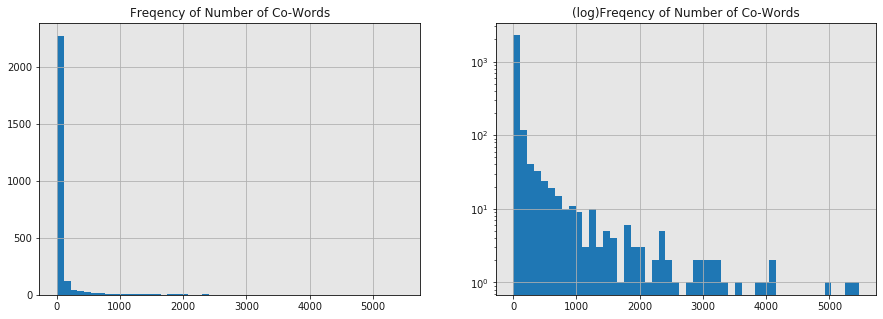

In [0]:
# part b - plot histogram (RUN THIS CELL AS IS - feel free to modify format)

# removing extreme upper tail for a better visual
counts = np.array(sample_counts)[np.array(sample_counts) < 6000]
t = sum(np.array(sample_counts) > 6000)
n = len(counts)
print("NOTE: we'll exclude the %s words with more than 6000 nbrs in this %s count sample." % (t,n))

# set up figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# plot regular hist
ax1.hist(counts, bins=50)
ax1.set_title('Freqency of Number of Co-Words', color='0.1')
ax1.set_facecolor('0.9')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)

# plot log scale hist
ax2.hist(counts, bins=50)
ax2.set_title('(log)Freqency of Number of Co-Words', color='0.1')
ax2.set_facecolor('0.9')
ax2.tick_params(axis='both', colors='0.1')
ax2.grid(True)
plt.yscale('log')


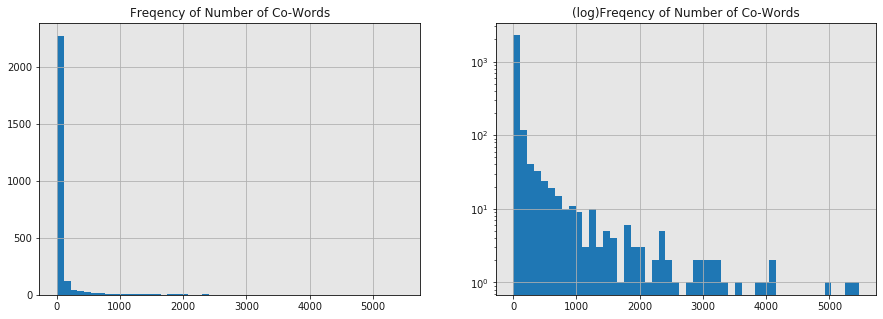

In [0]:
display(fig)

In [0]:
print("NOTE: we'll exclude the %s words with more than 6000 nbrs in this %s count sample." % (t,n))

NOTE: we'll exclude the 9 words with more than 6000 nbrs in this 2613 count sample.

In [0]:
# part c - spark job
def compareRankings(rdd1, rdd2):
    percent_overlap = None
    ############# YOUR CODE HERE ###############
    #new1RDD = rdd1.map(lambda x: x[0])
    #new2RDD = rdd2.map(lambda x: x[0])
    total = rdd1.count() 
    match = rdd1.join(rdd2).count()
    percent_overlap = 100*(match/total)
    ############# (END) YOUR CODE ##############
    return percent_overlap

In [0]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
total, topWords, bottomWords = EDA1(dataRDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(dataRDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
print(twRDD.take(10))
print(tnRDD.take(10))
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")
# Command took 5.30 minutes -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 4:59:01 PM on kyle_hw

[('the', 5490815394), ('of', 3698583299), ('to', 2227866570), ('in', 1421312776), ('a', 1361123022), ('and', 1149577477), ('that', 802921147), ('is', 758328796), ('be', 688707130), ('as', 492170314)]
[('the', 164982), ('of', 155708), ('and', 132814), ('in', 110615), ('to', 94358), ('a', 89197), ('by', 67266), ('with', 65127), ('that', 61174), ('as', 60652)]
Of the 1000 words with most neighbors, 88.0 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 1.9 percent are also in the list of 1000 least frequent words.

# Question 7: Basis Vocabulary & Stripes

Every word that appears in our data is a potential feature for our synonym detection analysis. However as we've discussed, some are likely to be more useful than others. In this question, you'll choose a judicious subset of these words to form our 'basis vocabulary' (i.e. feature set). Practically speaking, this means that when we build our stripes, we are only going to keep track of when a term co-occurs with one of these basis words. 


### Q7 Tasks:
* __a) short response:__ Suppose we were deciding between two different basis vocabularies: the 1000 most frequent words or the 1000 least frequent words. How would this choice impact the quality of the synonyms we are able to detect? How does this choice relate to the ideas of 'overfitting' or 'underfitting' a training set?

* __b) short response:__ If we had a much larger dataset, computing the full ordered list of words would be extremely expensive. If we need to none-the-less get an estimate of word frequency in order to decide on a basis vocabulary (feature set), what alternative strategy could we take?

* __c) code:__ Write a spark job that does the following:
  * tokenizes, removes stopwords and computes a word count on the ngram data
  * subsets the top 10,000 words (these are the terms we'll consider as potential synonyms)
  * subsets words 9,000-9,999 (this will be our 1,000 word basis vocabulary)    
  (to put it another way - of the top 10,000 words, the bottom 1,000 form the basis vocabulary)
  * saves the full 10K word list and the 1K basis vocabulary to file for use in `d`.  
  
  __NOTE:__ _to ensure consistency in results please use only the provided list of stopwords._  
  __NOTE:__ _as always, be sure to test your code on small files as you develop it._  

* __d) code:__ Write a spark job that builds co-occurrence stripes for the top 10K words in the ngram data using the basis vocabulary you developed in `part c`. This job/function, unlike others so far, should return an RDD (which we will then use in q8).

### Q7 Student Answers:
> __a)__ The quality of synonymns depend on how much context (stripe size) we have in the data for each of the term. The more context we have better the synonym detection. Thus, if we choose 1000 most frequent words our analysis shows it also has high number of co-occurances (large stripe size) which means we have lot more context to learn from and can provide better synonym analysis. If we were to choose the most frequent words we are overfitting the model with this training set. This means if we get a word that has a small stripe size (whether it is frequently occuring or not) we may not be able to identify its synonym most accurately. On the other hand if we choose 1000 least frequent words we are unable to say whether these words will have enough context (stripe size) and because of which we may underfit.

> __b)__ As an alternative strategy we could take many random samples and calculate word frequency and choose most frequent words across all samples as our basis vocaulary.

In [0]:
# part c - provided stopwords (RUN THIS CELL AS IS)
STOPWORDS =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 'should', 'can', 'now', 'will', 'just', 
              'would', 'could', 'may', 'must', 'one', 'much', "it's",
              "can't", "won't", "don't", "shouldn't", "hasn't"]

In [0]:
stopWords = sc.broadcast(set(STOPWORDS)) 

In [0]:
# part c - spark job
def get_vocab(rdd, n_total, n_basis):
    vocab, basis = None, None    
    ############# YOUR CODE HERE ###############
    def splitWords(payload):
      ngram, count, page, book = payload
      words = ngram.lower().split(" ")
      vocab = [w for w in words if w not in stopWords.value]
      for w in vocab:
        yield (w, int(count))
        
    result = rdd.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .takeOrdered(n_total, key=lambda x: -x[1])
    
    vocab = sc.parallelize(result).map(lambda x: x[0]).collect()
    basis = vocab[-n_basis:]
    ############# (END) YOUR CODE ##############
    return vocab, basis

In [0]:
# part c - run your job (RUN THIS CELL AS IS)
start = time.time()
VOCAB, BASIS = get_vocab(dataRDD, 10000, 1000)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 1.08 minutes -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 5:05:32 PM on kyle_hw

Wall time: 126.58910512924194 seconds

In [0]:
dbutils.fs.put(hw3_path+"vocabulary.txt",str(VOCAB),True)
dbutils.fs.put(hw3_path+"basis.txt",str(BASIS),True)

Wrote 113523 bytes.
Wrote 11948 bytes.
Out[60]: True

In [0]:
def buildStripes(rdd, vocab, basis):
    stripesRDD = None
    ############# YOUR CODE HERE ###############
    set_vocab = set(vocab)
    set_basis = set(basis)    
    def splitWords(payload):
      ngram, count, page, book = payload
      words = set(ngram.lower().split(" "))
      set_words = set([w for w in words if w in set_vocab])
      for w1 in set_words:
        stripe = {*()} # set()
        for w2 in set_words:
          if w1 !=w2 and w2 in set_basis:
            stripe.update([w2])
        if len(stripe) > 0:
          yield (w1, stripe)

    stripesRDD = rdd.map(lambda line: line.lower().split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y: x|y)
    ############# (END) YOUR CODE ##############
    return stripesRDD

In [0]:
# part d - run your systems test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(testRDD, 10, 10)
testStripesRDD = buildStripes(testRDD, VOCAB, BASIS)
start = time.time()
print(testStripesRDD.collect())
print("Wall time: {} seconds".format(time.time() - start))
# Command took 0.44 seconds -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 5:07:36 PM on kyle_hw
# Expected results
'''
[('worst', {'times'}), ('best', {'times'}), ('foolishness', {'age'}), ('times', {'age', 'best', 'worst'}), ('age', {'wisdom', 'foolishness', 'times'}), ('wisdom', {'age'})]
'''

[('worst', {'times'}), ('best', {'times'}), ('foolishness', {'age'}), ('age', {'wisdom', 'foolishness', 'times'}), ('wisdom', {'age'}), ('times', {'age', 'best', 'worst'})]
Wall time: 0.18566203117370605 seconds
Out[62]: "\n[('worst', {'times'}), ('best', {'times'}), ('foolishness', {'age'}), ('times', {'age', 'best', 'worst'}), ('age', {'wisdom', 'foolishness', 'times'}), ('wisdom', {'age'})]\n"

In [0]:
# part d - run your single file test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(f1RDD, 10000, 1000)
f1StripesRDD = buildStripes(f1RDD, VOCAB, BASIS).cache()
start = time.time()
print(f1StripesRDD.top(5))
print("Wall time: {} seconds".format(time.time() - start))
# Command took 3.02 seconds -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 5:09:34 PM on kyle_hw
# Expected results
'''
[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]
'''

[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]
Wall time: 1.069044589996338 seconds
Out[63]: "\n[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]\n"

In [0]:
# part d - run the full analysis and take a look at a few stripes (RUN THIS CELL AS IS)
VOCAB = ast.literal_eval(open(hw3_path_open+"vocabulary.txt", "r").read())
BASIS = ast.literal_eval(open(hw3_path_open+"basis.txt", "r").read())
stripesRDD = buildStripes(dataRDD, VOCAB, BASIS).cache()

start = time.time()
for wrd, stripe in stripesRDD.top(3):
    print(wrd)
    print(list(stripe))
    print('-------')
print("Wall time: {} seconds".format(time.time() - start))
# Command took 55.51 seconds -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 5:11:38 PM on kyle_hw
# Expected results:
'''
zur
['den']
-------
zones
['rupture', 'chalk', 'saturation', 'unification', 'inhibition', 'incentives', 'delimitation', 'shifting', 'molten', 'rings', 'privacy', 'israeli', 'allotted', 'mammals', 'variability', 'manipulation', 'hepatic', 'bridges', 'subordinated', 'earthquake', 'constituents']
-------
zone
['camps', 'touches', 'provisional', 'fibrous', 'saturation', 'evacuated', 'prostate', 'korean', 'inhibition', 'regulatory', 'soils', 'delimitation', 'overlap', 'rainfall', 'molten', 'narrowing', 'costa', 'penetrated', 'nuclei', 'rebuilt', 'antigens', 'lingering', 'glowing', 'privacy', 'suez', 'stretches', 'conduction', 'parked', 'retina', 'disregard', 'perpetually', 'surrounds', 'enlarge', 'thrive', 'breaker', 'volcano', 'precipitation', 'earthquake', 'cytoplasm', 'transfers', 'circumference']
-------
'''

zones
['remotest', 'adhesion', 'residential', 'subdivided', 'environments', 'gaza', 'saturation', 'localities', 'uppermost', 'warmer', 'buffer', 'parks']
-------
zone
['sandy', 'tribal', 'narrower', 'fibrous', 'saturation', 'originate', 'auxiliary', 'ie', 'buffer', 'transitional', 'turbulent', 'vomiting', 'articular', 'poorly', 'intervening', 'officially', 'accumulate', 'assisting', 'flexor', 'traversed', 'unusually', 'uppermost', 'cartilage', 'inorganic', 'illuminated', 'glowing', 'contamination', 'trigger', 'defines', 'masculine', 'avoidance', 'residential', 'southeastern', 'penis', 'cracks', 'atlas', 'excitation', 'diffuse', 'persia', 'subdivided', 'alaska', 'guides', 'au', 'americas', 'penetrating', 'parked']
-------
zinc
['ammonium', 'coating', 'pancreas', 'insoluble', "alzheimer's", 'radioactive', 'diamond', 'metallic', 'weighing', 'dysfunction', 'wasting', 'phosphorus', 'transcription', 'dipped', 'hydroxide', 'burns', 'leukemia', 'dietary']
-------
Wall time: 97.73701596260071 seconds
Out[64]: "\nzur\n['den']\n-------\nzones\n['rupture', 'chalk', 'saturation', 'unification', 'inhibition', 'incentives', 'delimitation', 'shifting', 'molten', 'rings', 'privacy', 'israeli', 'allotted', 'mammals', 'variability', 'manipulation', 'hepatic', 'bridges', 'subordinated', 'earthquake', 'constituents']\n-------\nzone\n['camps', 'touches', 'provisional', 'fibrous', 'saturation', 'evacuated', 'prostate', 'korean', 'inhibition', 'regulatory', 'soils', 'delimitation', 'overlap', 'rainfall', 'molten', 'narrowing', 'costa', 'penetrated', 'nuclei', 'rebuilt', 'antigens', 'lingering', 'glowing', 'privacy', 'suez', 'stretches', 'conduction', 'parked', 'retina', 'disregard', 'perpetually', 'surrounds', 'enlarge', 'thrive', 'breaker', 'volcano', 'precipitation', 'earthquake', 'cytoplasm', 'transfers', 'circumference']\n-------\n"

In [0]:
# print maximum number of stripes in stripesRDD
max(stripesRDD.mapValues(lambda x: len(x)).map(lambda x: x[1]).collect())

Out[82]: 894

In [0]:
stripesRDD.count()

Out[83]: 9993

In [0]:
len(set(BASIS))

Out[84]: 1000

In [0]:
# part d - save your full stripes to file for ease of retrival later... (OPTIONAL)
#stripesRDD.saveAsTextFile(hw3_path+'stripes')

# Question 8: Synonym Detection

We're now ready to perform the main synonym detection analysis. In the tasks below you will compute cosine, jaccard, dice and overlap similarity measurements for each pair of words in our vocabulary and then sort your results to find the most similar pairs of words in this dataset. __`IMPORTANT:`__ When you get to the sorting step please __sort on cosine similarity__ only, so that we can ensure consistent results from student to student. 

Remember to test each step of your work with the small files before running your code on the full dataset. This is a computationally intense task: well designed code can be the difference between a 20min job and a 2hr job. __`NOTE:`__ _as you are designing your code you may want to review questions 3 and 4 where we modeled some of the key pieces of this analysis._

### Q8 Tasks:
* __a) short response:__ In question 7 you wrote a function that would create word stripes for each `term` in our vocabulary. These word stripes are essentially an 'embedded representation' of the `term`'s meaning. What is the 'feature space' for this representation? (i.e. what are the features of our 1-hot encoded vectors?). What is the maximum length of a stripe?

* __b) short response:__ Remember that we are going to treat these stripes as 'documents' and perform similarity analysis on them. The first step is to emit postings which then get collected to form an 'inverted index.' How many rows will there be in our inverted index? Explain.

* __c) short response:__ In the demo from question 2, we were able to compute the cosine similarity directly from the stripes (we did this using their vector form, but could have used the list instead). So why do we need the inverted index? (__`HINT:`__ _see your answer to Q4a & Q4b_)

* __d) code:__ Write a spark job that does the following:
  * loops over the stripes from Q7 and emits postings for the `term` (_remember stripe = document_)
  * aggregates the postings to create an inverted index
  * loops over all pairs of `term`s that appear in the same inverted index and emits co-occurrence counts
  * aggregates co-occurrences
  * uses the counts (along with the accompanying information) to compute the cosine, jacard, dice and overlap similarity metrics for each pair of words in the vocabulary 
  * retrieve the top 20 and bottom 20 most/least similar pairs of words
  * also returned the cached sorted RDD for use in the next question  
  __`NOTE 1`:__ _Don't forget to include the stripe length when you are creating the postings & co-occurrence pairs. A composite key is the way to go here._  
  __`NOTE 2`:__ _Please make sure that your final results are sorted according to cosine similarity otherwise your results may not match the expected result & you will be marked wrong._
  
* __e) code:__ Comment on the quality of the "synonyms" your analysis comes up with. Do you notice anything odd about these pairs of words? Discuss at least one idea for how you might go about improving on the analysis.

### Q8 Student Answers:
> __a)__ The feature space is the BASIS. Thus, the theoritical maximum limit for size of stripe will be size of the BASIS. In this example BASIS consits of 1000 words. Thus the maximum size for any stripe will be 1000. In our case the maximum stripe size is 894

> __b)__ There will be 1000 rows in our inverted index.For each term in the BASIS we will have the total number of words in the document as well as co-occurance words.

> __c)__ We need the inverted index for 1 primary reason to avoid sparse matrix representation - (a)If we were to use vector calculaus we will have to represent the entire dataset as a sparse matrix which can require huge memory space to store the vocabulary and basis as well as during vector computation. This is unlike breaking the pieces into chuncks and running job in a parallel processing

> __e)__ It is difficult to discern the meaning of the word just by sorting the data using cosine similarity. Instead I will sort against the key like 'first' and look at all the pairs with "firts-" and do a secondary sort by cosine. This will allow me to see the progression of first with all the words which will then allow me to discern the meaning better.

In [0]:
# helper function for pretty printing (RUN THIS CELL AS IS)
def displayOutput(lines):
    template = "{:25}|{:6}, {:7}, {:7}, {:5}"
    print(template.format("Pair", "Cosine", "Jaccard", "Overlap", "Dice"))
    for pair, scores in lines:
        scores = [round(s,4) for s in scores]
        print(template.format(pair, *scores))

__`TIP:`__ Feel free to define helper functions within the main function to help you organize your code. Readability is important! Eg:
```
def similarityAnlysis(stripesRDD):
    """main docstring"""
    
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############ YOUR CODE HERE ###########
    def helper1():
        """helper docstring"""
        return x
        
    def helper2():
        """helper docstring"""
        return x
        
    # main spark job starts here
    
        ...etc
    ############ (END) YOUR CODE ###########
    return simScoresRDD, top_n, bottom_n
```

In [0]:
# part d - write your spark job in the space provided
import math
def similarityAnalysis(stripesRDD, n):
    """
    This function defines a Spark DAG to compute cosine, jaccard, 
    overlap and dice scores for each pair of words in the stripes
    provided. 
    
    Output: an RDD, a list of top n, a list of bottom n
    """
    simScoresRDD, top_n, bottom_n = None, None, None    
    ############### YOUR CODE HERE ################
    def splitWords(pair):
      """Mapper 2: tokenize each document and emit postings."""
      doc, words = pair
      for w in words:
        yield (w, [(doc,len(words))])
        
    def makeCompositeKey(inverted_index):
      """Mapper 3: loop over postings and yield pairs."""
      word, postings = inverted_index
      # taking advantage of symmetry, output only (a,b), but not (b,a)
      for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)
    
    def simMetrics(line):
      """Mapper 4: compute similarity scores"""
      (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
      total = int(line[1])
      minof = min(int(n1), int(n2))
      cosine = total / math.sqrt(float(int(n1)*int(n2)))
      jaccard = total / float(int(n1) + int(n2) - total)
      overlap = total / float(minof)
      dice = (2*jaccard) / (1+jaccard)
      yield ((doc1+" - "+doc2), (cosine, jaccard, overlap, dice))

    simScoresRDD = stripesRDD.flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(simMetrics) \
             .cache()
    
    top_n = simScoresRDD.takeOrdered(n, key=lambda x: -x[1][0])
    bottom_n = simScoresRDD.takeOrdered(n, key=lambda x: x[1][0])
    ############### (END) YOUR CODE ##############
    return simScoresRDD, top_n, bottom_n

In [0]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
testResult, top_n, bottom_n = similarityAnalysis(testStripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 0.40 seconds -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 5:15:03 PM on kyle_hw

Wall time: 0.38147640228271484 seconds

In [0]:
displayOutput(top_n)

Pair |Cosine, Jaccard, Overlap, Dice 
best - worst | 1.0, 1.0, 1.0, 1.0
foolishness - wisdom | 1.0, 1.0, 1.0, 1.0
times - wisdom |0.5774, 0.3333, 1.0, 0.5
age - best |0.5774, 0.3333, 1.0, 0.5
age - worst |0.5774, 0.3333, 1.0, 0.5
foolishness - times |0.5774, 0.3333, 1.0, 0.5

In [0]:
displayOutput(bottom_n)

Pair |Cosine, Jaccard, Overlap, Dice 
times - wisdom |0.5774, 0.3333, 1.0, 0.5
age - best |0.5774, 0.3333, 1.0, 0.5
age - worst |0.5774, 0.3333, 1.0, 0.5
foolishness - times |0.5774, 0.3333, 1.0, 0.5
best - worst | 1.0, 1.0, 1.0, 1.0
foolishness - wisdom | 1.0, 1.0, 1.0, 1.0

In [0]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
f1Result, top_n, bottom_n = similarityAnalysis(f1StripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 1.11 seconds -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 5:15:34 PM on kyle_hw

Wall time: 0.7741522789001465 seconds

In [0]:
displayOutput(top_n)

Pair |Cosine, Jaccard, Overlap, Dice 
contemplated - prize | 1.0, 1.0, 1.0, 1.0
conceived - generality | 1.0, 1.0, 1.0, 1.0
conceived - reality | 1.0, 1.0, 1.0, 1.0
generality - simplicity | 1.0, 1.0, 1.0, 1.0
reality - simplicity | 1.0, 1.0, 1.0, 1.0
expect - rigid | 1.0, 1.0, 1.0, 1.0
facts - rigid | 1.0, 1.0, 1.0, 1.0
antibody - excess | 1.0, 1.0, 1.0, 1.0
ecological - excess | 1.0, 1.0, 1.0, 1.0
ecological - stable | 1.0, 1.0, 1.0, 1.0

In [0]:
displayOutput(bottom_n)

Pair |Cosine, Jaccard, Overlap, Dice 
part - time |0.0294, 0.0149, 0.0303, 0.0294
time - two |0.0309, 0.0156, 0.0333, 0.0308
time - upon |0.0314, 0.0159, 0.0345, 0.0312
made - time |0.0325, 0.0164, 0.037, 0.0323
first - time |0.0338, 0.0169, 0.04, 0.0333
made - two |0.0351, 0.0179, 0.037, 0.0351
new - time |0.0352, 0.0175, 0.0435, 0.0345
part - us |0.0355, 0.0179, 0.0417, 0.0351
little - part |0.0355, 0.0179, 0.0417, 0.0351
made - upon |0.0357, 0.0182, 0.037, 0.0357

In [0]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
result, top_n, bottom_n = similarityAnalysis(stripesRDD, 20)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 4.66 minutes -- by kylehamilton@ischool.berkeley.edu at 9/19/2020, 5:16:00 PM on kyle_hw

Wall time: 433.5727686882019 seconds

In [0]:
displayOutput(top_n)

Pair |Cosine, Jaccard, Overlap, Dice 
first - time | 0.89, 0.8012, 0.9149, 0.8897
time - well |0.8895, 0.801, 0.892, 0.8895
great - time | 0.875, 0.7757, 0.925, 0.8737
part - well | 0.874, 0.7755, 0.9018, 0.8735
first - well |0.8717, 0.7722, 0.8936, 0.8715
part - time |0.8715, 0.7715, 0.9018, 0.871
time - upon |0.8668, 0.763, 0.9152, 0.8656
made - time | 0.866, 0.7619, 0.9109, 0.8649
made - well |0.8601, 0.7531, 0.9022, 0.8592
time - way |0.8587, 0.7487, 0.9259, 0.8563
great - well |0.8526, 0.7412, 0.8988, 0.8514
time - two |0.8517, 0.7389, 0.9094, 0.8498
first - great |0.8497, 0.7381, 0.8738, 0.8493
first - part |0.8471, 0.7348, 0.8527, 0.8471
great - upon |0.8464, 0.7338, 0.8475, 0.8464
upon - well |0.8444, 0.729, 0.889, 0.8433
new - time |0.8426, 0.724, 0.9133, 0.8399
first - two |0.8411, 0.7249, 0.8737, 0.8405
way - well |0.8357, 0.7146, 0.8986, 0.8335
time - us |0.8357, 0.7105, 0.9318, 0.8308

In [0]:
displayOutput(bottom_n)

Pair |Cosine, Jaccard, Overlap, Dice 
region - write |0.0067, 0.0032, 0.0085, 0.0065
relation - snow |0.0067, 0.0026, 0.0141, 0.0052
cardiac - took |0.0074, 0.0023, 0.0217, 0.0045
ever - tumor |0.0076, 0.002, 0.0263, 0.004
came - tumor |0.0076, 0.002, 0.0263, 0.004
let - therapy |0.0076, 0.003, 0.0161, 0.0059
related - stay |0.0078, 0.0036, 0.0116, 0.0072
factors - hear |0.0078, 0.0039, 0.0094, 0.0077
implications - round |0.0078, 0.0033, 0.0145, 0.0066
came - proteins |0.0079, 0.002, 0.0286, 0.0041
population - window |0.0079, 0.0039, 0.01, 0.0077
love - proportional | 0.008, 0.0029, 0.0185, 0.0058
got - multiple | 0.008, 0.0034, 0.0149, 0.0067
changes - fort |0.0081, 0.0032, 0.0161, 0.0065
layer - wife |0.0081, 0.0038, 0.0119, 0.0075
five - sympathy |0.0081, 0.0034, 0.0149, 0.0068
arrival - essential |0.0081, 0.004, 0.0093, 0.008
desert - function |0.0081, 0.0031, 0.0175, 0.0062
fundamental - stood |0.0081, 0.0038, 0.0115, 0.0077
patients - plain |0.0081, 0.004, 0.0103, 0.0079

In [0]:
result.count()

Out[97]: 28757658

__Expected output f1RDD:__  
<table>
<th>MOST SIMILAR:</th>
<th>LEAST SIMILAR:</th>
<tr><td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
commentary - lady        |   1.0,     1.0,     1.0,   1.0
commentary - toes        |   1.0,     1.0,     1.0,   1.0
commentary - reply       |   1.0,     1.0,     1.0,   1.0
curious - tone           |   1.0,     1.0,     1.0,   1.0
curious - lady           |   1.0,     1.0,     1.0,   1.0
curious - owe            |   1.0,     1.0,     1.0,   1.0
lady - tone              |   1.0,     1.0,     1.0,   1.0
reply - tone             |   1.0,     1.0,     1.0,   1.0
lady - toes              |   1.0,     1.0,     1.0,   1.0
lady - reply             |   1.0,     1.0,     1.0,   1.0
</pre></td>
<td><pre>

Pair                     |Cosine, Jaccard, Overlap, Dice 
part - time              |0.0294,  0.0149,  0.0303, 0.0294
time - upon              |0.0314,  0.0159,  0.0345, 0.0312
time - two               |0.0314,  0.0159,  0.0345, 0.0312
made - time              |0.0325,  0.0164,   0.037, 0.0323
first - time             |0.0338,  0.0169,    0.04, 0.0333
new - time               |0.0352,  0.0175,  0.0435, 0.0345
part - us                |0.0355,  0.0179,  0.0417, 0.0351
little - part            |0.0355,  0.0179,  0.0417, 0.0351
made - two               |0.0357,  0.0182,   0.037, 0.0357
made - upon              |0.0357,  0.0182,   0.037, 0.0357
</pre></td></tr>
</table>

__Expected output dataRDD:__  
<table>
<th>Most Similar</th>
<th>Least Similar</th>
<tr><td><pre>
Pair           |Cosine, Jaccard, Overlap, Dice 
cain - ceres             |   1.0,     1.0,     1.0,   1.0
gyration - oscillation   |   1.0,     1.0,     1.0,   1.0
prosecutor - reconstructed|   1.0,     1.0,     1.0,   1.0
condolence - zur         |   1.0,     1.0,     1.0,   1.0
sociedad - verde         |   1.0,     1.0,     1.0,   1.0
hong - kong              |0.8906,  0.7931,     1.0, 0.8846
cava - vena              |0.8819,  0.7778,     1.0, 0.875
first - time             |0.8715,  0.7703,  0.9199, 0.8703
time - well              |0.8639,  0.7599,    0.89, 0.8636
great - time             |0.8563,  0.7453,   0.921, 0.8541
time - way               |0.8525,  0.7396,  0.9169, 0.8503
part - time              | 0.846,  0.7308,  0.8989, 0.8445
nova - scotia            |0.8452,  0.7143,     1.0, 0.8333
great - upon             |0.8448,  0.7312,  0.8488, 0.8447
time - upon              |0.8447,  0.7283,  0.9042, 0.8428
new - time               |0.8428,  0.7239,  0.9164, 0.8398
part - well              |0.8406,  0.7244,   0.867, 0.8402
states - united          |0.8383,  0.7214,  0.8541, 0.8382
made - time              |0.8371,  0.7155,  0.9096, 0.8342
first - new              |0.8287,   0.707,  0.8538, 0.8284
</pre></td>
<td><pre>
Pair                  |Cosine, Jaccard, Overlap, Dice 
city - renal             |0.0075,  0.0025,    0.02, 0.005
differentiation - house  |0.0084,  0.0023,  0.0286, 0.0045
effectiveness - got      |0.0085,  0.0034,  0.0167, 0.0068
conditions - pulled      |0.0085,  0.0036,  0.0156, 0.0072
legislative - story      |0.0086,  0.0034,  0.0179, 0.0067
duty - located           |0.0086,   0.004,   0.013, 0.0079
group - listening        |0.0087,   0.003,  0.0217, 0.006
resulting - thou         |0.0087,  0.0041,  0.0122, 0.0082
completely - library     |0.0087,  0.0043,  0.0106, 0.0086
membrane - service       |0.0088,  0.0033,  0.0192, 0.0066
concentrations - never   |0.0088,   0.002,  0.0357, 0.004
highly - st              |0.0088,  0.0044,  0.0099, 0.0087
associated - kitchen     |0.0088,  0.0035,  0.0175, 0.007
calcium - government     |0.0088,  0.0024,  0.0294, 0.0049
complex - sat            |0.0088,  0.0044,  0.0095, 0.0088
agricultural - immediately|0.0089,  0.0039,  0.0152, 0.0077
st - tendency            |0.0089,  0.0044,  0.0099, 0.0088
bosom - theory           |0.0089,  0.0036,  0.0175, 0.0072
members - wet            |0.0089,  0.0032,  0.0213, 0.0063
values - window          |0.0089,  0.0045,  0.0099, 0.0089
</pre></td></tr>
</table>

### Congratulations, you have completed HW3! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform